**Test**: Equal Number of Real News and Fake News from Global South, and checking PRA values.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install tensorflo


ERROR: Could not find a version that satisfies the requirement tensorflo (from versions: none)
ERROR: No matching distribution found for tensorflo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History

from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import Embedding
from keras.layers import Reshape, Flatten
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D
from keras.layers import AveragePooling1D, Input, Dropout, concatenate

from wordcloud import WordCloud, STOPWORDS

import pickle
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

##read data

###North

In [ ]:
'''
This cell is primarily from global north
'''
# For ISOT Dataset
df1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/Fake.csv', delimiter=',')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GN.csv', delimiter = ',')
df1['label'] = 0
df2['label'] = 1
df_isot = pd.concat([df1,df2])
df_isot = df_isot[['text','label']]
print(df_isot.shape)

num_class_A_train = np.sum(df_isot['label'] == 0)
num_class_B_train = np.sum(df_isot['label'] == 1)
print(num_class_A_train)
print(num_class_B_train)

(40025, 2)
23481
16544


In [ ]:
# Separate features and labels
X = df_isot[['text']]
y = df_isot['label']

oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(df_isot[['text']], df_isot['label'])

# Create a new DataFrame with resampled data
df_isot = pd.DataFrame(X_resampled, columns=['text'])
df_isot['label'] = y_resampled

# Check the class distribution after oversampling
print(df_isot['label'].value_counts())

0    23481
1    23481
Name: label, dtype: int64


###South

In [ ]:
# For IND
df_ind = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/IND/IND_poli.csv')
df_ind['label'] = 1
# df_ind.columns
df_ind = df_ind[['News Abstract','label']]
df_ind.columns = ['text', 'label']
df_ind.shape

(200, 2)

In [ ]:
# For FNI
df_fni_full = pd.read_excel('/content/drive/MyDrive/Datasets_BTP/FNI/fakenewsincidents_india_dataset_v1.xls')
df_fni_full['label'] = 0
df_fni_full = df_fni_full[['Content','label']]
df_fni_full.columns = ['text', 'label']
df_fni_full.shape

(4802, 2)

In [ ]:
df_isot_gs = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GS.csv', delimiter = ',')
df_isot_gs['label'] = 1
df_isot_gs = df_isot_gs[['text', 'label']]
df_isot_gs.shape

(4873, 2)

In [ ]:
df_toi_1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/12-02-2024-Articles.csv')
df_toi_2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/13-02-2024-Articles.csv')
df_toi_3 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/14-02-2024-Articles.csv')
df_toi_4 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/12-02-2024-Articles.csv')
df_toi_5 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/16-02-2024-Articles.csv')
df_toi_6 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/20-02-2024-Articles.csv')
df_toi_7 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/24-02-2024-Articles.csv')
df_toi_8 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/9-02-2024-Articles.csv')
df_toi = pd.concat([df_toi_1, df_toi_2, df_toi_3, df_toi_4, df_toi_5, df_toi_6, df_toi_7, df_toi_8])

df_toi['label'] = 1
df_toi = df_toi[['text', 'label']]

df_toi.shape

(668, 2)

In [ ]:
# FOR DATASETS COMBINED
df_gs = pd.concat([df_fni_full, df_ind, df_toi, df_isot_gs])
df_gs.shape

num_class_A_train = np.sum(df_gs['label'] == 0)
num_class_B_train = np.sum(df_gs['label'] == 1)
print(num_class_A_train)
print(num_class_B_train)

4802
5741


In [ ]:
X = df_gs[['text']]
y = df_gs['label']

oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(df_gs[['text']], df_gs['label'])

# Create a new DataFrame with resampled data
df_gs = pd.DataFrame(X_resampled, columns=['text'])
df_gs['label'] = y_resampled

# Check the class distribution after oversampling
print(df_gs['label'].value_counts())

0    5741
1    5741
Name: label, dtype: int64


###Tokenizer

In [ ]:
X = df_gs[['text']]
y = df_gs['label']

X_isot = df_isot[['text']]
y_isot = df_isot['label']

targetCount = 6200
strategy = {0: targetCount, 1: targetCount}
ros = RandomOverSampler(sampling_strategy=strategy, random_state=42)
rus = RandomUnderSampler(sampling_strategy=strategy, random_state=42)

X_resampled, y_resampled = ros.fit_resample(X, y)
Xus, yus = rus.fit_resample(X_isot, y_isot)

df_gs = pd.DataFrame(X_resampled, columns=['text'])
df_gs['label'] = y_resampled

df_isot = pd.DataFrame(Xus, columns=['text'])
df_isot['label'] = yus

print(df_gs['label'].value_counts())
print(df_isot['label'].value_counts())

df = pd.concat([df_gs, df_isot])

print(df['label'].value_counts())

0    6200
1    6200
Name: label, dtype: int64
0    6200
1    6200
Name: label, dtype: int64
0    12400
1    12400
Name: label, dtype: int64


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (6200) in class 0 will be larger than the number of samples in the majority class (class #0 -> 5741)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (6200) in class 1 will be larger than the number of samples in the majority class (class #0 -> 5741)
  warnings.warn(


In [ ]:
# Maximum number of words to be embedded
NUM_WORDS = 30000
EMBEDDING_DIM=100
# max length to be encoded for a sentence
MAX_SEQUENCE_LENGTH = 1000

# Define Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
# tokenizer1 = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
# tokenizer2 = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)

df_isot['text'] = df_isot['text'].astype(str)
df_gs['text'] = df_gs['text'].astype(str)

# Fit the function on the text
tokenizer.fit_on_texts(df['text'])
# tokenizer1.fit_on_texts(df_isot['text'])
# tokenizer2.fit_on_texts(df_gs['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
# sequences1 = tokenizer1.texts_to_sequences(df_isot['text'])
# sequences2 = tokenizer2.texts_to_sequences(df_gs['text'])

# pad the data to the same length
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
# data_isot = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
# data_gs = pad_sequences(sequences2, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

# Count number of unique tokens
word_index = tokenizer.word_index
# word_index1 = tokenizer1.word_index
# word_index2 = tokenizer2.word_index
print('Found %s unique tokens.' % len(word_index))
# print('Found %s unique tokens.' % len(word_index1))
# print('Found %s unique tokens.' % len(word_index2))

Found 73537 unique tokens.
Found 71815 unique tokens.


In [ ]:
# word_index = {**word_index1, **word_index2}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_isot, df_isot[['label']], test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_gs, df_gs[['label']], test_size=0.2, random_state=42)

X_train = np.concatenate([X_train, X_train2], axis=0)
y_train = pd.concat([y_train, y_train2])
X_test = np.concatenate([X_test, X_test2], axis=0)
y_test = pd.concat([y_test, y_test2])

In [ ]:
print(y_train.shape)

(19840, 1)


In [ ]:
num_class_A_train = np.sum(y_train == 0)
num_class_B_train = np.sum(y_train == 1)
num_class_A_test = np.sum(y_test == 0)
num_class_B_test = np.sum(y_test == 1)
print(num_class_A_train)
print(num_class_A_test)
print(num_class_B_train)
print(num_class_B_test)

label    9923
dtype: int64
label    2477
dtype: int64
label    9917
dtype: int64
label    2483
dtype: int64


### glove embedding

In [ ]:
word_vectors = dict()

# load the whole embedding into memory
f = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [ ]:
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))
#vocabulary_size= len(word_index)+1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
      # if the word is not found, set to all 0s
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

#del(word_vectors)

In [ ]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
embedding_matrix.shape

(30000, 100)

In [ ]:
X_train.shape

(19840, 1000)

In [ ]:
# del(embedding_matrix)

### tokenized with LogisticRegression

In [ ]:
xtrain, xvald, ytrain, yvald = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
num_class_A_train = np.sum(ytrain == 0)
num_class_B_train = np.sum(ytrain == 1)
num_class_A_test = np.sum(yvald == 0)
num_class_B_test = np.sum(yvald == 1)
print(num_class_A_train)
print(num_class_A_test)
print(num_class_B_train)
print(num_class_B_test)

label    7966
dtype: int64
label    1957
dtype: int64
label    7906
dtype: int64
label    2011
dtype: int64


In [ ]:
epochs = 40
batch_size = 128

modelA = Sequential()
modelA.add(Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

modelA.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
modelA.add(MaxPooling1D(4))
modelA.add(Dropout(0.3))

modelA.add(Flatten())
modelA.add(Dense(units = 128 , activation = 'relu'))
modelA.add(Dropout(0.3))
modelA.add(Dense(1, activation='sigmoid'))
modelA.summary()
modelA.compile(loss='binary_crossentropy',
              optimizer='Adadelta',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,          # Will print messages when early stopping triggers
                               mode='min',         # The direction is automatically inferred if not set but can be set to 'min' or 'max'
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

history = modelA.fit(xtrain, ytrain, validation_data = (xvald,yvald), epochs=epochs, verbose=1, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         3000000   
                                                                 
 conv1d (Conv1D)             (None, 997, 128)          51328     
                                                                 
 max_pooling1d (MaxPooling1  (None, 249, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 249, 128)          0         
                                                                 
 flatten (Flatten)           (None, 31872)             0         
                                                                 
 dense (Dense)               (None, 128)               4079744   
                                                        

In [ ]:
loss, pr, recall = modelA.evaluate(X_test, y_test)
print(pr)
print(recall)

155/155 [==============================] - 1s 4ms/step - loss: 0.3300 - precision: 0.8624 - recall: 0.8429
0.8623815178871155
0.8429319262504578


In [ ]:
# define model
modelB = Sequential()
modelB.add(embedding_layer)
modelB.add(Flatten())
modelB.add(Dense(1, activation='sigmoid'))
# compile the model
modelB.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# summarize the model
modelB.summary()

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,          # Will print messages when early stopping triggers
                               mode='min',         # The direction is automatically inferred if not set but can be set to 'min' or 'max'
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

# fit the model
modelB.fit(xtrain, ytrain, validation_data = (xvald,yvald), epochs=epochs, batch_size=128, verbose=1, callbacks=[early_stopping])
# loss,accuracy = model.evaluate(X_test,y_test)
# print('Accuracy: %f' % (accuracy*100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         3000000   
                                                                 
 flatten_1 (Flatten)         (None, 100000)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 100001    
                                                                 
Total params: 3100001 (11.83 MB)
Trainable params: 100001 (390.63 KB)
Non-trainable params: 3000000 (11.44 MB)
_________________________________________________________________
Epoch 1/40
124/124 [==============================] - 2s 6ms/step - loss: 0.4703 - precision_1: 0.8129 - recall_1: 0.8297 - val_loss: 0.2258 - val_precision_1: 0.9013 - val_recall_1: 0.9309
Epoch 2/40
124/124 [==============================] - 1s 4ms/step - loss: 0.1063 - 

In [ ]:
loss, pr, recall = modelB.evaluate(X_test, y_test)
print(pr)
print(recall)

155/155 [==============================] - 1s 4ms/step - loss: 0.1570 - precision_1: 0.9500 - recall_1: 0.9340
0.9500204920768738
0.9339508414268494


### FNDNet

In [ ]:
num_kernels = 128
kernel_sizes= [3,4,5]
pool_sizes = [800,799,798]

#embed_input = Input(shape=(max_length,))
#x = Embedding(vocab_size,output_dim,input_length=max_length)(embed_input)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embed_input = embedding_layer(inputs)

pool_outputs = []
for i in range(len(kernel_sizes)):
    conv = Conv1D(num_kernels, kernel_size=kernel_sizes[i], padding='valid', activation='relu')(embed_input)
    pool = MaxPooling1D(pool_size=pool_sizes[i], strides=1, padding = 'valid')(conv)
    pool_outputs.append(pool)
merge = concatenate(pool_outputs,axis = 1)

conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(merge)
pool = MaxPooling1D(pool_size=5)(conv)
conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(pool)
pool = MaxPooling1D(pool_size=30)(conv)

x = Flatten()(pool)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
modelC = Model(inputs=inputs,outputs=x)
modelC.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 100)            3000000   ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 998, 128)             38528     ['embedding[1][0]']           
                                                                                                  
 conv1d_2 (Conv1D)           (None, 997, 128)             51328     ['embedding[1][0]']           
                                                                                              

In [ ]:
modelC.compile(loss='binary_crossentropy',
              #optimizer='Adadelta',
              optimizer='Adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
epochs = 40
batch_size = 128
xtrain, xvald, ytrain, yvald = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,          # Will print messages when early stopping triggers
                               mode='min',         # The direction is automatically inferred if not set but can be set to 'min' or 'max'
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

# Fit the model with the early stopping callback
modelC.fit(xtrain, ytrain,
           epochs=epochs,
           validation_data=(xvald, yvald),
           batch_size=batch_size,
           verbose=1,
           callbacks=[early_stopping])

Epoch 1/40
124/124 [==============================] - 23s 149ms/step - loss: 0.3352 - precision_2: 0.8319 - recall_2: 0.8282 - val_loss: 0.0999 - val_precision_2: 0.9785 - val_recall_2: 0.9488
Epoch 2/40
124/124 [==============================] - 18s 149ms/step - loss: 0.0428 - precision_2: 0.9859 - recall_2: 0.9884 - val_loss: 0.0616 - val_precision_2: 0.9791 - val_recall_2: 0.9761
Epoch 3/40
124/124 [==============================] - 18s 147ms/step - loss: 0.0082 - precision_2: 0.9973 - recall_2: 0.9981 - val_loss: 0.0816 - val_precision_2: 0.9613 - val_recall_2: 0.9886
Epoch 4/40
124/124 [==============================] - 18s 145ms/step - loss: 0.0197 - precision_2: 0.9923 - recall_2: 0.9946 - val_loss: 0.0694 - val_precision_2: 0.9782 - val_recall_2: 0.9816
Epoch 5/40
124/124 [==============================] - 18s 146ms/step - loss: 0.0017 - precision_2: 0.9994 - recall_2: 0.9995 - val_loss: 0.0752 - val_precision_2: 0.9782 - val_recall_2: 0.9831
Epoch 5: early stopping


In [ ]:
loss, pr, recall = modelC.evaluate(X_test, y_test)
print(pr)
print(recall)

155/155 [==============================] - 2s 12ms/step - loss: 0.0634 - precision_2: 0.9762 - recall_2: 0.9766
0.9762479662895203
0.9766411781311035


In [ ]:
# # Save the trained model as a pickle string.
# import pickle

# saved_model_path = 'modelA_saved_eq.pkl'
# with open(saved_model_path, 'wb') as file:
#     pickle.dump(modelA, file)

# saved_model_path = 'modelB_saved_eq.pkl'
# with open(saved_model_path, 'wb') as file:
#     pickle.dump(modelB, file)

# saved_model_path = 'modelC_saved_eq.pkl'
# with open(saved_model_path, 'wb') as file:
#     pickle.dump(modelC, file)

##Tests Actual

In [ ]:
# Maximum number of words to be embedded
testbench_fni = pd.read_excel('/content/drive/MyDrive/Datasets_BTP/FNI/fakenewsincidents_india_dataset_v1.xls')
testbench_fni['label'] = 0
testbench_fni = testbench_fni[['Content', 'label']]
testbench_fni.columns = ['text', 'label']
testbench_fni.text=testbench_fni.text.astype(str)
print(testbench_fni.shape)
# testbench_fni = testbench_fni.sample(200)

testbench_ind = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/IND/IND_poli.csv')
testbench_ind['label'] = 1
# testbench_ind.columns
testbench_ind = testbench_ind[['News Abstract','label']]
testbench_ind.columns = ['text', 'label']
print(testbench_ind.shape)

t1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/12-02-2024-Articles.csv')
t2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/13-02-2024-Articles.csv')
t3 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/14-02-2024-Articles.csv')
t4 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/16-02-2024-Articles.csv')
t5 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/20-02-2024-Articles.csv')
t6 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/9-02-2024-Articles.csv')
t7 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/24-02-2024-Articles.csv')

testbench_toi = pd.concat([t1,t2,t3,t4,t5,t6,t7])
testbench_toi['label'] = 1
testbench_toi = testbench_toi[['text', 'label']]
testbench_gs_isot = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GS.csv', delimiter = ',')
testbench_gs_isot['label'] = 1
testbench_gs_isot = testbench_gs_isot[['text', 'label']]
print(testbench_toi.columns)
print(testbench_toi.shape)
testbench_gs = pd.concat([testbench_gs_isot, testbench_toi, testbench_ind, testbench_fni])
print(testbench_gs.shape)

sample_gn = 200
testbench_isot_fake = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/Fake.csv', delimiter=',')
testbench_isot_real = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GN.csv', delimiter = ',')
# testbench_isot_fake.head
testbench_isot_fake['label'] = 0
testbench_isot_real['label'] = 1
testbench_isot = pd.concat([testbench_isot_fake,testbench_isot_real])
testbench_isot_real.shape

(4802, 2)
(200, 2)
Index(['text', 'label'], dtype='object')
(584, 2)
(10459, 2)


(16544, 6)

###GN Data

In [ ]:
# modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_eq.pkl', 'rb'))
# modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_eq.pkl', 'rb'))
# modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_eq.pkl', 'rb'))

testbench_isot = df_isot

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

tsample0 = testbench_isot_fake
tsample1 = testbench_isot_real
testbench_isot = pd.concat([tsample0,tsample1])

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(testbench_isot['text'])
sequences = tokenizer.texts_to_sequences(testbench_isot['text'])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

loss, pr, re = modelA.evaluate(data, testbench_isot[['label']])
prStatsA.append(pr)
f1StatsA.append((2*pr*re)/(pr+re))
reStatsA.append(re)

loss, pr, re = modelB.evaluate(data, testbench_isot[['label']])
prStatsB.append(pr)
f1StatsB.append((2*pr*re)/(pr+re))
reStatsB.append(re)

loss, pr, re = modelC.evaluate(data, testbench_isot[['label']])
prStatsC.append(pr)
f1StatsC.append((2*pr*re)/(pr+re))
reStatsC.append(re)

1251/1251 [==============================] - 15s 12ms/step - loss: 1.1220 - precision_2: 0.5370 - recall_2: 0.5566


In [ ]:
prA = []
f1A = []
reA = []

prB = []
f1B = []
reB = []

prC = []
f1C = []
reC = []

x = []

for i in range(10,100,5):
  train, test, trainLabel, testLabel = train_test_split(data, testbench_isot[['label']], test_size=(i/100), random_state=42)
  x.append(test.shape[0])
  loss, pr, re = modelA.evaluate(test, testLabel)
  prA.append(pr)
  f1A.append((2*pr*re)/(pr+re))
  reA.append(re)

  loss, pr, re = modelB.evaluate(test, testLabel)
  prB.append(pr)
  f1B.append((2*pr*re)/(pr+re))
  reB.append(re)

  loss, pr, re = modelC.evaluate(test, testLabel)
  prC.append(pr)
  f1C.append((2*pr*re)/(pr+re))
  reC.append(re)

1189/1189 [==============================] - 15s 12ms/step - loss: 1.1232 - precision_2: 0.5366 - recall_2: 0.5568


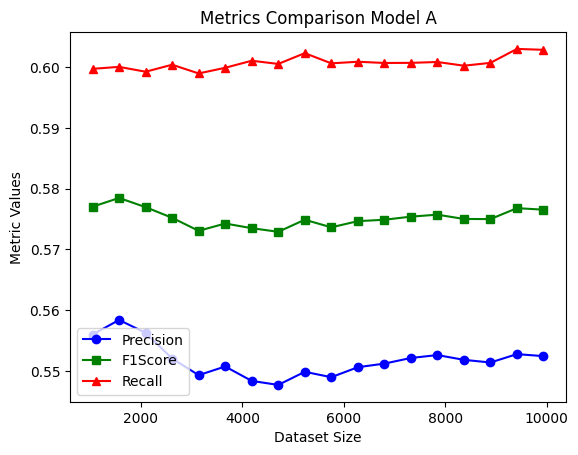

In [ ]:
plt.plot(x, prA, label='Precision', color='blue', marker='o')
plt.plot(x, f1A, label='F1Score', color='green', marker='s')
plt.plot(x, reA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

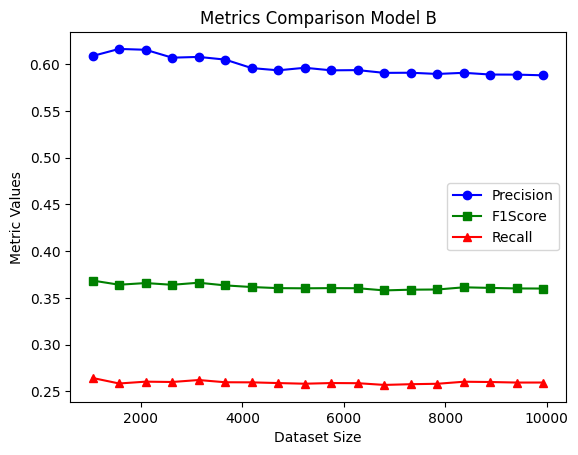

In [ ]:
plt.plot(x, prB, label='Precision', color='blue', marker='o')
plt.plot(x, f1B, label='F1Score', color='green', marker='s')
plt.plot(x, reB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

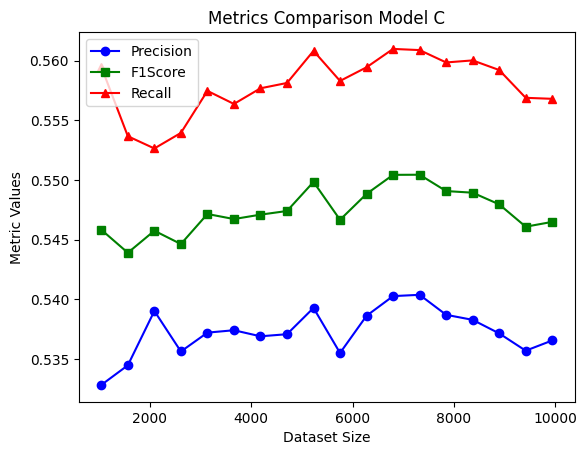

In [ ]:
plt.plot(x, prC, label='Precision', color='blue', marker='o')
plt.plot(x, f1C, label='F1Score', color='green', marker='s')
plt.plot(x, reC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

###GS Data

In [ ]:
# modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_eq.pkl', 'rb'))
# modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_eq.pkl', 'rb'))
# modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_eq.pkl', 'rb'))

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

testbench_curr = testbench_gs

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(testbench_curr['text'])
sequences = tokenizer.texts_to_sequences(testbench_curr['text'])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

loss, pr, re = modelA.evaluate(data, testbench_curr[['label']])
prStatsA.append(pr)
f1StatsA.append((2*pr*re)/(pr+re))
reStatsA.append(re)

loss, pr, re = modelB.evaluate(data, testbench_curr[['label']])
prStatsB.append(pr)
f1StatsB.append((2*pr*re)/(pr+re))
reStatsB.append(re)

loss, pr, re = modelC.evaluate(data, testbench_curr[['label']])
prStatsC.append(pr)
f1StatsC.append((2*pr*re)/(pr+re))
reStatsC.append(re)

327/327 [==============================] - 4s 13ms/step - loss: 1.5012 - precision_2: 0.5616 - recall_2: 0.4851


In [ ]:
prA2 = []
f1A2 = []
reA2 = []

prB2 = []
f1B2 = []
reB2 = []

prC2 = []
f1C2 = []
reC2 = []

x = []
for i in range(10,100,5):
  train, test, trainLabel, testLabel = train_test_split(data, testbench_curr[['label']], test_size=(i/100), random_state=42)
  x.append(test.shape[0])

  loss, pr, re = modelA.evaluate(test, testLabel)
  prA2.append(pr)
  f1A2.append((2*pr*re)/(pr+re))
  reA2.append(re)

  loss, pr, re = modelB.evaluate(test, testLabel)
  prB2.append(pr)
  f1B2.append((2*pr*re)/(pr+re))
  reB2.append(re)

  loss, pr, re = modelC.evaluate(test, testLabel)
  prC2.append(pr)
  f1C2.append((2*pr*re)/(pr+re))
  reC2.append(re)

311/311 [==============================] - 4s 14ms/step - loss: 1.4953 - precision_2: 0.5634 - recall_2: 0.4864


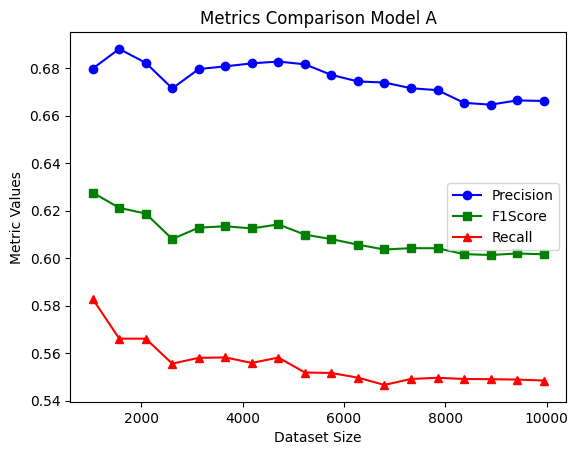

In [ ]:
plt.plot(x, prA2, label='Precision', color='blue', marker='o')
plt.plot(x, f1A2, label='F1Score', color='green', marker='s')
plt.plot(x, reA2, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

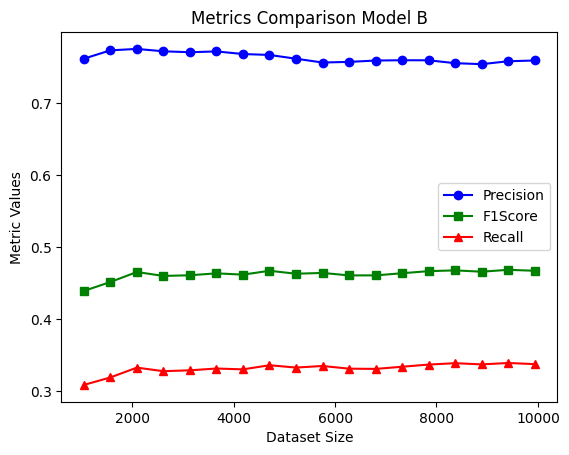

In [ ]:
plt.plot(x, prB2, label='Precision', color='blue', marker='o')
plt.plot(x, f1B2, label='F1Score', color='green', marker='s')
plt.plot(x, reB2, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

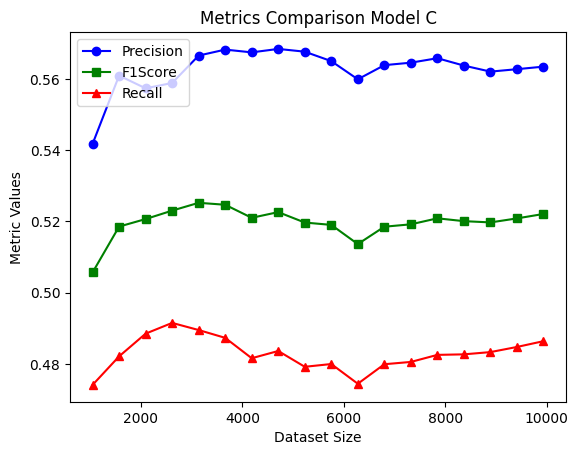

In [ ]:
plt.plot(x, prC2, label='Precision', color='blue', marker='o')
plt.plot(x, f1C2, label='F1Score', color='green', marker='s')
plt.plot(x, reC2, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

###North Vs South Comparision

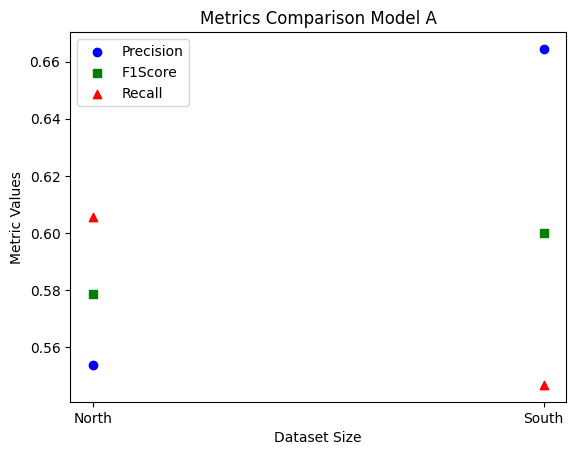

In [ ]:
plt.scatter(['North','South'], prStatsA, label='Precision', color='blue', marker='o')
plt.scatter(['North','South'], f1StatsA, label='F1Score', color='green', marker='s')
plt.scatter(['North','South'], reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

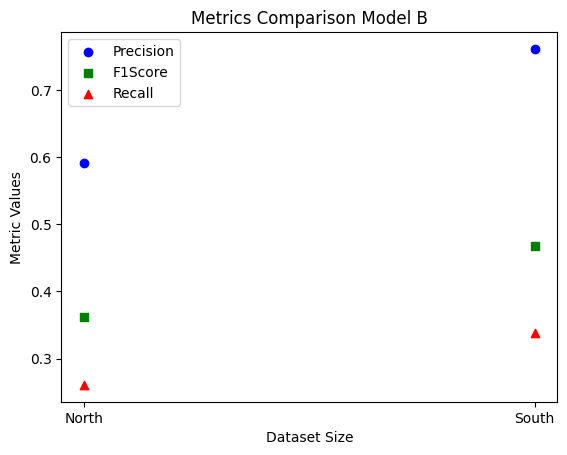

In [ ]:
plt.scatter(['North','South'], prStatsB, label='Precision', color='blue', marker='o')
plt.scatter(['North','South'], f1StatsB, label='F1Score', color='green', marker='s')
plt.scatter(['North','South'], reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

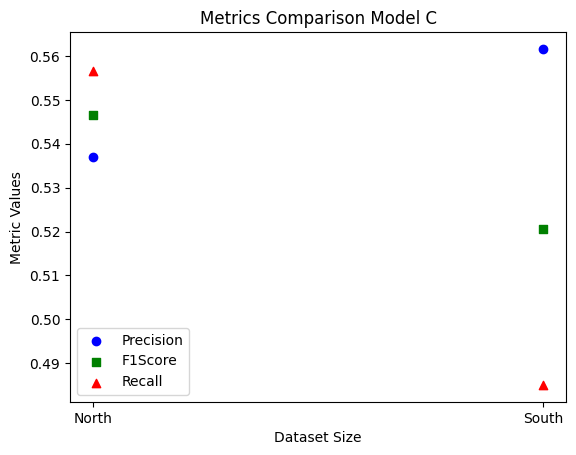

In [ ]:
plt.scatter(['North','South'], prStatsC, label='Precision', color='blue', marker='o')
plt.scatter(['North','South'], f1StatsC, label='F1Score', color='green', marker='s')
plt.scatter(['North','South'], reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison Model C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()